# Simulation code

Simulating the forecaste evaluation time takes a significant time. This program is only for simulation and is slightly faster. This is because the horizon is equal to 1, so we can set the bandwidth parameter of the Bartlett kernel equal to zero. The three models are also seperate. This code is 10% faster than the evaluation code.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [2]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

## Test statistics TR

In [118]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size,iterations_CV))

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get psi (scalar)
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                         TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                       for i in range(grid_elements)])
    
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))

    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))
#     print(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1).shape)
#     print(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size].shape)
    residual_sel = L_t - Q_sel[:,:,-1] @ psi
#     print(np.sum(np.absolute(residual_sel),axis=1))
    score = Q_sel[:,:,-1] * residual_sel
 
    score_trans = np.transpose(score, (0, 2, 1))
        
    lambda_sum = score_trans @ v_t

    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
 
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    V_star = M_P_inv @ V_P @ M_P_inv

    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    lambda_P = np.transpose(lambda_sum / P_size**0.5,(0,2,1))

    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)
        
    crit_values = np.max(W_P_j,axis=0)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

#     print(g_theta)    
    # Sort the Monte Carlo simulations and get critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
#     print("W_P:",W_P)
#     print("g_theta:",g_theta)
#     print("Crit value:",final_crit_value)
    # Check if the test statistic 
    if (g_theta > final_crit_value):
        return 1,g_theta,final_crit_value
    else:
        return 0,g_theta,final_crit_value

## Test statistics LSTR

## Test statistics ESTR


## Model 1

In [4]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

In [121]:
def MonteCarlo_1(iterations,R,P,T):
    
    #define variable to keep track of amount of rejects
    MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(iterations))
#     plt.plot(g_theta_arr)
#     plt.show()
    return np.mean(MC_array)
    
def MonteCarlo_1(iterations,R,P,T):
    MC_array =np.zeros(iterations)    
    #define variable to keep track of amount of rejects
    
    
    for i in range(iterations):
        MC_array[i] = MonteCarlo_iteration_1(R,P,T)    
     
    return np.mean(MC_array)

def MonteCarlo_iteration_1(R,P,T):
    #simulate model, it only returns vectors:
    sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T)

    delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, T)
    
    return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R, P_size=P,T_size=T)

def sim_model_1(T):
    delta1 = delta2 = v = 1
    z1 = np.random.normal(0,1,(T,1))
    z2 = np.random.normal(0,1,(T,1))
    S_t = np.random.normal(0,1,(T,1))
    
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T,1))
#     print("delta1",delta1)
#     print("v",v)
#     print("S_t",S_t)
#     print("z1",z1)
#     print("y_t",np.mean(y_t))
#     print("y_t",np.std(y_t))
    
    #return vector values
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, T):
    sim_z1 = np.column_stack([np.ones((T,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T,1)),sim_z2])

    delta_L = np.zeros((P,1))
        
    for t in range(R, T):
        z1_sel = sim_z1[t-R:t]
        z2_sel = sim_z2[t-R:t]
        y_sel = sim_y_t[t-R:t]
        
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        forecast1 = beta_1[0] + z1_sel[-1,1] * beta_1[1]
        forecast2 = beta_2[0] + z2_sel[-1,1] * beta_2[1]

#         print("True",y_sel[-1])
#         print(forecast1)
#         print(forecast2)
        delta_L[t-R] = (y_sel[-1] - forecast1)**2 - (y_sel[-1] - forecast2)**2
#     print("mean",np.mean(delta_L))
#     print("var",np.std(delta_L))
#     plt.hist(delta_L,bins=200)
#     plt.show()
    return delta_L

def MonteCarlo_2(iterations,R,P,T,c):
        
    #define variable to keep track of amount of rejects
    MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_2)(R,P,T,c) for i in range(iterations))
    
    return np.mean(MC_array)
    
def MonteCarlo_2(iterations,R,P,T,c):
    MC_array =np.zeros(iterations)
    a =np.zeros(iterations)
    b=np.zeros(iterations)
    #define variable to keep track of amount of rejects
    
    for i in range(iterations):
        MC_array[i],a[i],b[i] = MonteCarlo_iteration_2(R,P,T,c)    
    
    plt.hist(a,bins=30)
    plt.show()
    plt.hist(b,bins=30)
    plt.show()
        
    return np.mean(MC_array)

    
def MonteCarlo_iteration_2(R,P,T,c):
    #z1 t = 0
    #z2 t = 0
    #S  t = 0
    #L  t = 1
    #y  t = 1
    
    #simulate model, it only returns vectors:
    sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T)

    delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R, P, T)

    delta_L = cal_delta_L_2(delta_L_1,sim_S_t[R-1:T-1],c)
    
    return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R, P_size=P,T_size=T)


def cal_delta_L_2(delta_L_old,S_sel,c):
    gamma = 0
    
    mu = np.linspace(0,1,14)[c]
    theta = -2*mu
    
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
#     print(delta_L)
#     print(S_sel)
#     plt.plot(delta_L)
#     plt.plot(S_sel)
#     plt.show()
#     print("corr:",np.corrcoef(delta_L.T,S_sel.T))
    return delta_L

Choose one of the following model types:
1. "TR"
2. "LSTR"
3. "ESTR"

In [20]:
#simulation speed:
MC_iterations = 3000
grid_elements = 20
iterations_CV = 200
signi_level = 0.05

# You can modify these variables
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

print("---TR model---")
for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(MC_iterations,R_MC,P_MC,T_MC))

---TR model---
For R = 25
And P = 50


KeyboardInterrupt: 

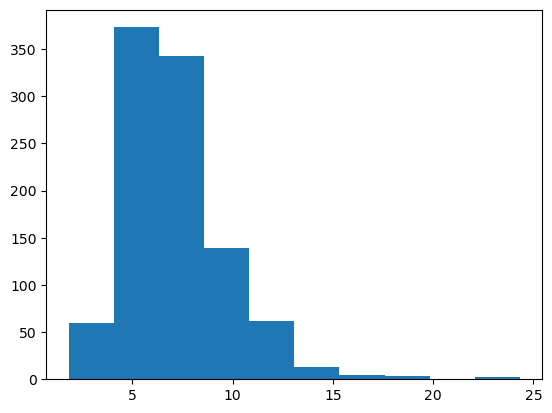

In [134]:
arr = np.zeros(1000)
for i in range(1000):
    arr[i] = max(np.random.chisquare(2,20))
plt.hist(arr)
plt.show()

---TR model---
For c = 1


C:\Users\joche\AppData\Local\Temp\ipykernel_11304\2486587426.py:86: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i],a[i],b[i] = MonteCarlo_iteration_2(R,P,T,c)


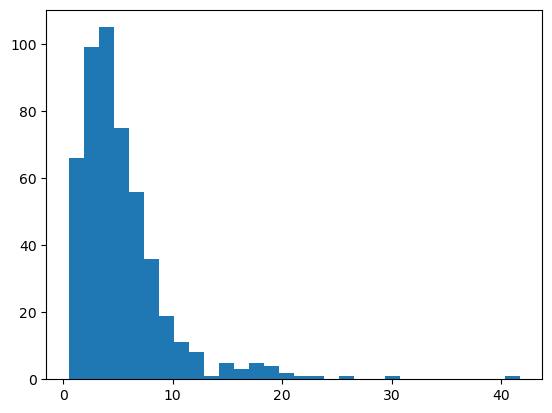

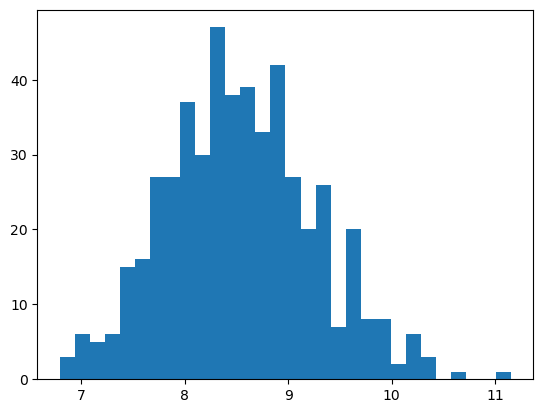

The rejection rate is 0.132


In [130]:
#simulation speed:
MC_iterations = 500
grid_elements = 10
iterations_CV = 200
signi_level = 0.05

# You can modify these variables
R_MC = 50
P_MC = 50
T_MC = R_MC + P_MC

c_array  = np.arange(14)

print("---TR model---")
for c in [0]:#c_array:
    print("For c =",c+1)
    print("The rejection rate is",MonteCarlo_2(MC_iterations,R_MC,P_MC,T_MC,c))

In [71]:
crit_chi_iterations = 10000

chi_array = np.stack(max(np.random.chisquare(2,20)) for i in range(crit_chi_iterations))
chi_array = np.sort(chi_array)
crit_chi = chi_array[round((1-signi_level) * crit_chi_iterations)-1]
crit_chi

12.082922613248522

0.0